## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from tqdm import tqdm

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli
from qiskit.transpiler.passes.optimization.light_cone import LightCone
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.utils.remove_barriers import RemoveBarriers
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp

10000
from_hard_paper
Restricted license - for non-production use only - expires 2026-11-23
1000
random_ratio
500
random_ratio


/var/folders/bm/9lz4gv9d21gf9g5dwnm7rgym0000gn/T/ipykernel_76565/1037893798.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))


50
random_ratio
5
inversely_strongly_correlated
10
Inversely strongly correlated


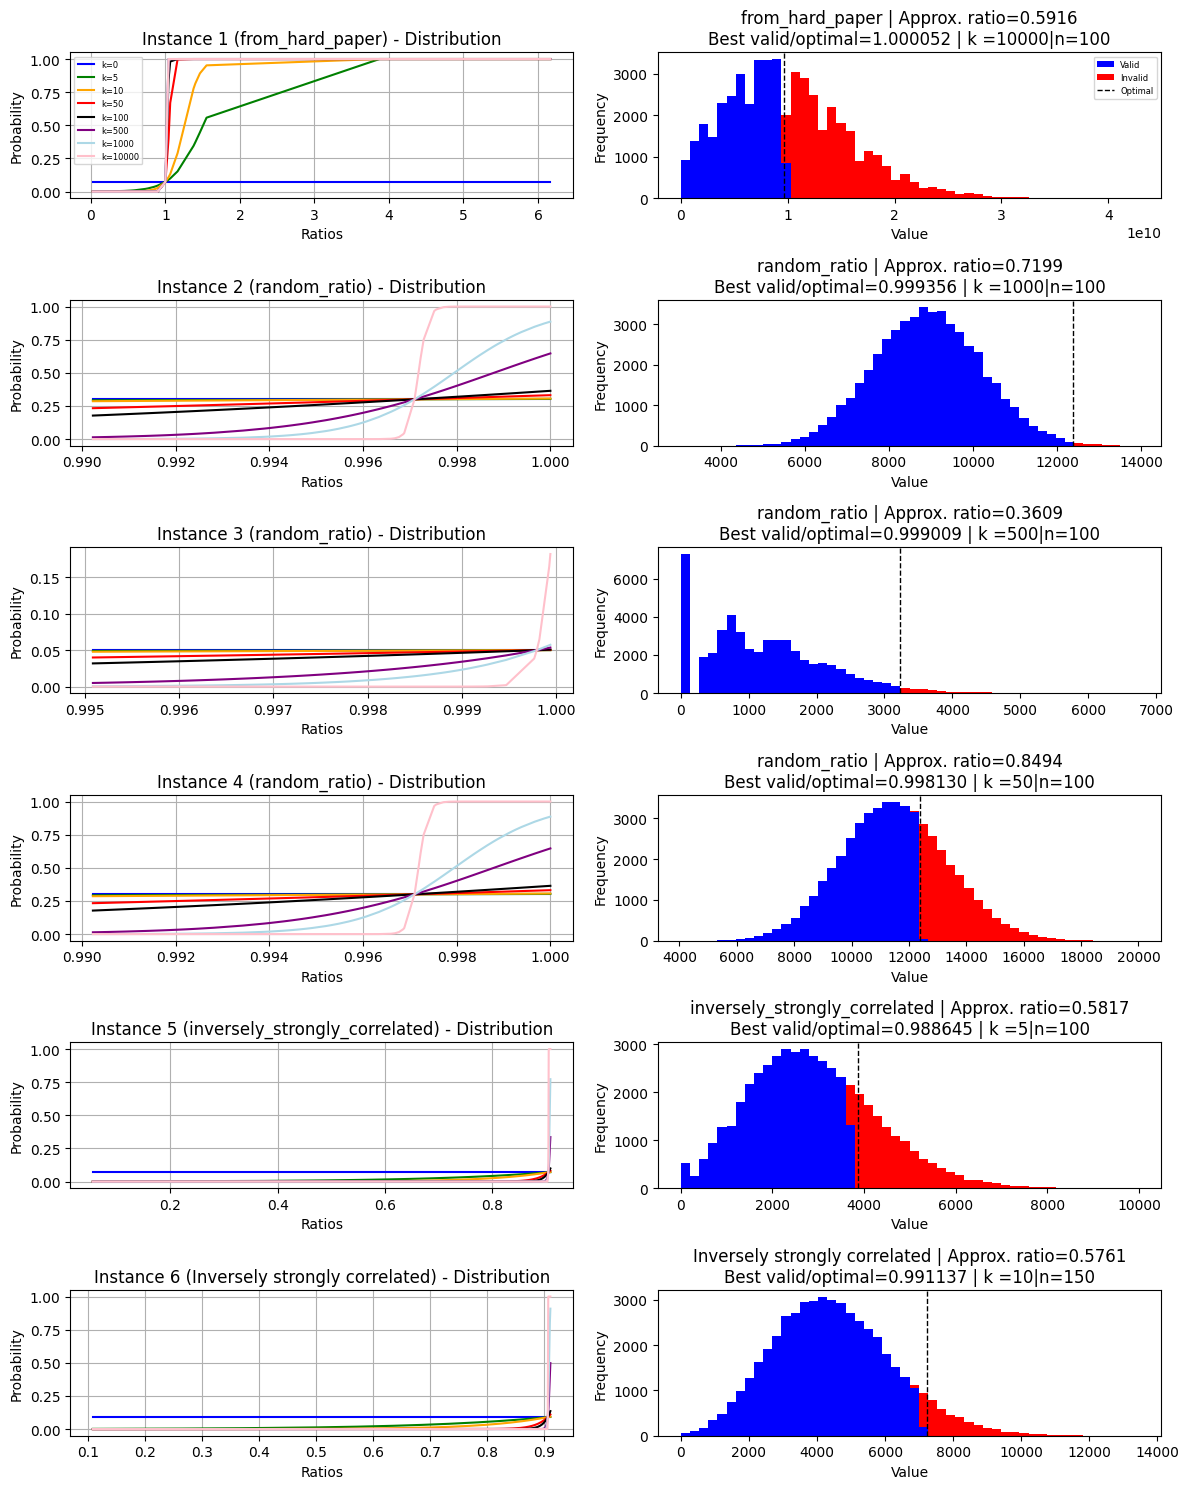

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ast  # safely parse string lists
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver
def construct_lazy_greedy_solution(weights, ratios, capacity):
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(len(weights), dtype=bool)
    greedy_order = np.lexsort((-weights, -ratios))
    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    ratios = values / weights
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, ratios, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution])
    uniform_probability = np.sum(weights) / capacity
    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

def load_knapsacks(file):
    instances = []
    with h5py.File(file, "r") as f:
        for key in sorted(f.keys(), key=lambda x: int(x)):
            grp = f[key]
            instance = {}
            for k, v in grp.items():
                data = v[()]
                if isinstance(data, bytes):
                    data = data.decode("utf-8")
                if isinstance(data, str) and data.startswith("[") and data.endswith("]"):
                    try:
                        data = np.array(ast.literal_eval(data), dtype=float)
                    except Exception:
                        pass
                if isinstance(data, np.generic):
                    data = data.item()
                instance[k] = data
            instances.append(instance)
    return instances

# Dummy solver for demonstration (replace with your Gurobi function)


# Load data
instances = load_knapsacks("knapsacks.h5")

k_values = [0, 5, 10, 50, 100, 500, 1000, 10000]
colours = ['blue', 'green', 'orange', 'red', 'k', 'purple', 'lightblue', 'pink']

# Prepare one figure with side-by-side panels per instance
n_instances = min(len(instances), 6)
fig, axes = plt.subplots(n_instances, 2, figsize=(12, 2.5 * n_instances))
axes = np.atleast_2d(axes)  # ensure consistent indexing

for idx, instance in enumerate(instances[:n_instances]):
    weights = np.array(instance["weights"])
    values = np.array(instance["values"])
    capacity = instance["capacity"]
    type_ = instance["type"]
    k = instance["k"]
    print(k)
    n=instance["n"]
    print(instance["type"])
    ratios = values / weights
    if instance["type"]=="from_hard_paper":
        OG=0.1
    else:
        OG=1e-9
    result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                            time_limit=60,
                                            optimality_gap=OG,
                                            feasibility_tolerance=1e-9)

    optimal_value = result_gurobi['total_value']
    optimal_weight = result_gurobi['total_weight']

    # --- Left panel: Smoothed distributions
    ax = axes[idx, 0]
    for i, k_val in enumerate(k_values):
        smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_val)
        ordered_indices = np.argsort(ratios)
        ax.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices],
                color=colours[i], label=f'k={k_val}')
    ax.set_title(f'Instance {idx+1} ({type_}) - Distribution')
    ax.set_xlabel('Ratios')
    ax.set_ylabel('Probability')
    ax.grid(True)
    if idx == 0:
        ax.legend(fontsize=6)

    # --- Right panel: Histogram of sample values
    
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
    num_samples = 50000
    samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
    total_values = np.sum(samples * values, axis=1)
    total_weights = np.sum(samples * weights, axis=1)
    valid_samples = total_weights <= capacity

    probability_valid = np.sum(valid_samples) / num_samples
    approximation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

    ax2 = axes[idx, 1]
    ax2.hist([total_values[valid_samples], total_values[~valid_samples]],
             bins=50, stacked=True, color=['blue', 'red'], label=['Valid', 'Invalid'])
    ax2.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal')
    ax2.set_title(
    f'{type_} | Approx. ratio={approximation_ratio_of_valid:.4f}\n'
    f'Best valid/optimal={np.max(total_values[valid_samples]) / optimal_value:.6f} | k ={k}|n={n}'
)

    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    if idx == 0:
        ax2.legend(fontsize=6)

plt.tight_layout()
plt.show()


# How 

### How to save more instances

In [49]:
import h5py
import numpy as np

import h5py
import numpy as np

def save_knapsack_hdf5(file, instance):
    # Ensure all arrays are NumPy arrays and handle strings
    cleaned_instance = {}
    for k, v in instance.items():
        if isinstance(v, np.ndarray):
            cleaned_instance[k] = v
        elif isinstance(v, (int, float)):
            cleaned_instance[k] = v
        else:  # convert strings or lists to proper HDF5 types
            cleaned_instance[k] = str(v)

    # Open HDF5 file in append mode
    with h5py.File(file, "a") as f:
        # determine next dataset name
        next_id = str(len(f) + 1)
        grp = f.create_group(next_id)

        for key, value in cleaned_instance.items():
            if isinstance(value, np.ndarray):
                grp.create_dataset(key, data=value)
            elif isinstance(value, (int, float)):
                grp.create_dataset(key, data=value)
            else:  # string
                dt = h5py.string_dtype(encoding="utf-8")
                grp.create_dataset(key, data=value, dtype=dt)

    print(f"✅ Saved instance #{next_id} in {file}")

# Example usage
instance = {
    "n":n,
    "k":k,
    "weights": weights.tolist(),
    "values": values.tolist(),
    "capacity": capacity,
    "type": "inversely_strongly_correlated"
}       
save_knapsack_hdf5("knapsacks.h5", instance)  


✅ Saved instance #5 in knapsacks.h5


# how to remove an instance

In [ ]:
import h5py

def remove_last_instance(file):
    with h5py.File(file, "a") as f:
        if len(f) == 0:
            print("⚠️ No instances to remove.")
            return
        
        # Find the last group name (highest index)
        last_id = str(len(f))
        del f[last_id]
        print(f"Removed instance #{last_id} from {file}")
remove_last_instance("knapsacks.h5")

🗑️ Removed instance #6 from knapsacks.h5
